In [1]:
import requests
import matplotlib.pyplot as plt
from IPython.display import display, Image
from io import BytesIO

from pymol import cmd
import py3Dmol

# from vina import Vina

# from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from meeko import MoleculePreparation
from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf
from prolif.plotting.network import LigNetwork

#### conda install schrodinger::pymol

In [7]:
uriprot_id = "p08183"
pdb_id="4R3C"

In [26]:
#rcsb database 
ress=requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb",pdb_id)
with open(f"{pdb_id}.pdb",'wb') as file :
    file.write(ress.content)

In [27]:
# AlphaFold2 Database
response = requests.get("https://alphafold.ebi.ac.uk/api/prediction/"+uriprot_id)
data = response.json()[0]

In [28]:
headers={"Accept": "application/json", "Content-Type": "application/json"} 
ress=requests.get("https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=10&organism=homo", headers=headers)

In [29]:
ress2=requests.get("https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=10&protein=p08183", headers=headers)

In [30]:
data_uniprot = ress2.json()

In [31]:
for i in data_uniprot:
    print(i)

{'accession': 'U4LL60', 'id': 'U4LL60_PYROM', 'proteinExistence': 'Inferred from homology', 'info': {'type': 'TrEMBL', 'created': '2013-12-11', 'modified': '2024-03-27', 'version': 58}, 'organism': {'taxonomy': 1076935, 'names': [{'type': 'scientific', 'value': 'Pyronema omphalodes (strain CBS 100304)'}, {'type': 'common', 'value': 'Pyronema confluens'}], 'lineage': ['Eukaryota', 'Fungi', 'Dikarya', 'Ascomycota', 'Pezizomycotina', 'Pezizomycetes', 'Pezizales', 'Pyronemataceae', 'Pyronema']}, 'protein': {'submittedName': [{'fullName': {'value': 'Similar to Multidrug resistance protein 1 acc. no. P08183', 'evidences': [{'code': 'ECO:0000313', 'source': {'name': 'EMBL', 'id': 'CCX13655.1', 'url': 'https://www.ebi.ac.uk/ena/browser/view/CCX13655.1'}}]}}]}, 'gene': [{'orfNames': [{'value': 'PCON_13248', 'evidences': [{'code': 'ECO:0000313', 'source': {'name': 'EMBL', 'id': 'CCX13655.1', 'url': 'https://www.ebi.ac.uk/ena/browser/view/CCX13655.1'}}]}]}], 'comments': [{'type': 'SUBCELLULAR_LOC

In [32]:
params_uniprot = ['id', 'text', 'url', ' ligand']

In [33]:
heads={"Accept": "application/json",
"Accept-Encoding": "gzip, deflate, br, zstd",
"Accept-Language":"en-US,en;q=0.9",
"Connection":"keep-alive",
"Content-Type": "application/json",
"Host": "www.ebi.ac.uk"
}

In [34]:
resp=requests.get("https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=10&protein=insulin", headers=heads)
uniprot_data = resp.json()
# uniprot_data

In [35]:
def extract_uniprot_ids(pdb_file_path):
    uniprot_ids = []

    with open(pdb_file_path, 'r') as file:
        for line in file:
            if line.startswith("REMARK 800 SITE_DESCRIPTION: BINDING SITE FOR RESIDUE"):
                # Example DBREF line format:
                # DBREF   1  A  100  120  1  P12345  1  20  100  120  1
                parts = line.split()
                # UniProt ID is usually the 7th element in the DBREF line
                uniprot_id = parts[7:]
                if uniprot_id:
                    uniprot_ids.append(uniprot_id)
    
    return uniprot_ids


# Example usage
pdb_file_path = '4R3C.pdb'  # Replace with your PDB file path
uniprot_ids = extract_uniprot_ids(pdb_file_path)
print("UniProt IDs found:", uniprot_ids)


UniProt IDs found: [['GG5', 'A', '401'], ['3GF', 'A', '402'], ['3GF', 'A', '403'], ['CL', 'A', '404']]


In [36]:
ligand_list=[]
for i in uniprot_ids:
    ligand = "_".join(i)
    ligand_list.append(ligand)
ligand_list

['GG5_A_401', '3GF_A_402', '3GF_A_403', 'CL_A_404']

In [37]:
# LINK         NE2 HIS A  87                FE   HEM A 142     1555   1555  2.14  
# LINK         NE2 HIS B  92                FE   HEM B 148     1555   1555  2.22  
# LINK         NE2 HIS C  87                FE   HEM C 142     1555   1555  2.26  
# LINK         NE2 HIS D  92                FE   HEM D 148     1555   1555  1.98  


In [40]:
def extract_uniprot_ids(pdb_file_path):
    uniprot_ids = []

    with open(pdb_file_path, 'r') as file:
        for line in file:
            if line.startswith("HETATM"):
                # Example DBREF line format:
                # DBREF   1  A  100  120  1  P12345  1  20  100  120  1
                parts = line.split()
                # UniProt ID is usually the 7th element in the DBREF line
                uniprot_id = parts
                if uniprot_id:
                    uniprot_ids.append(uniprot_id)
    
    return uniprot_ids


# Example usage
pdb_file_path = '4R3C.pdb'  # Replace with your PDB file path
uniprot_ids = extract_uniprot_ids(pdb_file_path)
print("UniProt IDs found:", uniprot_ids)


UniProt IDs found: [['HETATM', '1332', 'N', 'CME', 'A', '162', '72.097', '62.310', '25.491', '1.00', '42.89', 'N'], ['HETATM', '1333', 'CA', 'CME', 'A', '162', '73.268', '63.037', '24.958', '1.00', '43.70', 'C'], ['HETATM', '1334', 'CB', 'CME', 'A', '162', '74.645', '62.407', '25.248', '1.00', '49.55', 'C'], ['HETATM', '1335', 'SG', 'CME', 'A', '162', '74.877', '62.210', '26.995', '1.00', '65.41', 'S'], ['HETATM', '1336', 'SD', 'CME', 'A', '162', '75.419', '64.119', '27.332', '0.70', '63.56', 'S'], ['HETATM', '1337', 'CE', 'CME', 'A', '162', '74.121', '64.459', '28.482', '0.70', '64.01', 'C'], ['HETATM', '1338', 'CZ', 'CME', 'A', '162', '74.620', '64.232', '29.901', '0.70', '67.12', 'C'], ['HETATM', '1339', 'OH', 'CME', 'A', '162', '73.493', '64.089', '30.772', '0.70', '69.56', 'O'], ['HETATM', '1340', 'C', 'CME', 'A', '162', '73.154', '63.342', '23.480', '1.00', '38.35', 'C'], ['HETATM', '1341', 'O', 'CME', 'A', '162', '74.141', '63.732', '22.856', '1.00', '36.33', 'O'], ['HETATM', '2

In [ ]:
# SITE_DESCRIPTION: BINDING SITE FOR RESIDUE 4H3C 
# SITE_DESCRIPTION: BINDING SITE FOR RESIDUE 2H8H
# SITE_DESCRIPTION: BINDING SITE FOR RESIDUE 6SMB

In [10]:
import time 
def run_protoss(pdb_id):
    url = 'https://proteins.plus/api/protoss_rest'
    payload = {"protoss": {"pdbCode": pdb_id}}
    headers={"Accept": "application/json", "Content-Type": "application/json"}
    response = requests.post(url, json=payload, headers=headers, timeout=30)
    response.raise_for_status()
    time.sleep(5)        
    if response.status_code==200:
        loc=response.json()['location']
        job_response = requests.get(loc)
        return job_response.json()
    else:
        return 'Unknown Server Error'


In [11]:
processed_data = run_protoss(pdb_id)
protein = processed_data['protein']
ligands = processed_data['ligands']
log = processed_data['log']

In [41]:
ligand_id="3GF_A_402"

In [42]:
headers={"Accept": "application/json", "Content-Type": "application/json"} 
params = {
            "poseview": {
            "pdbCode":pdb_id,
            "ligand":ligand_id}
            }
     
response = requests.post("https://proteins.plus/api/poseview_rest",headers=headers,json=params)
location = response.json()['location']
visuals = requests.get(location).json()
img=requests.get(visuals['result_png_picture'])
visuals['result_png_picture']

'https://proteins.plus/results/poseview/Zs8JNSfKwwBWD3nXrMa1Er7w/4r3c_3GF_A_402.png'

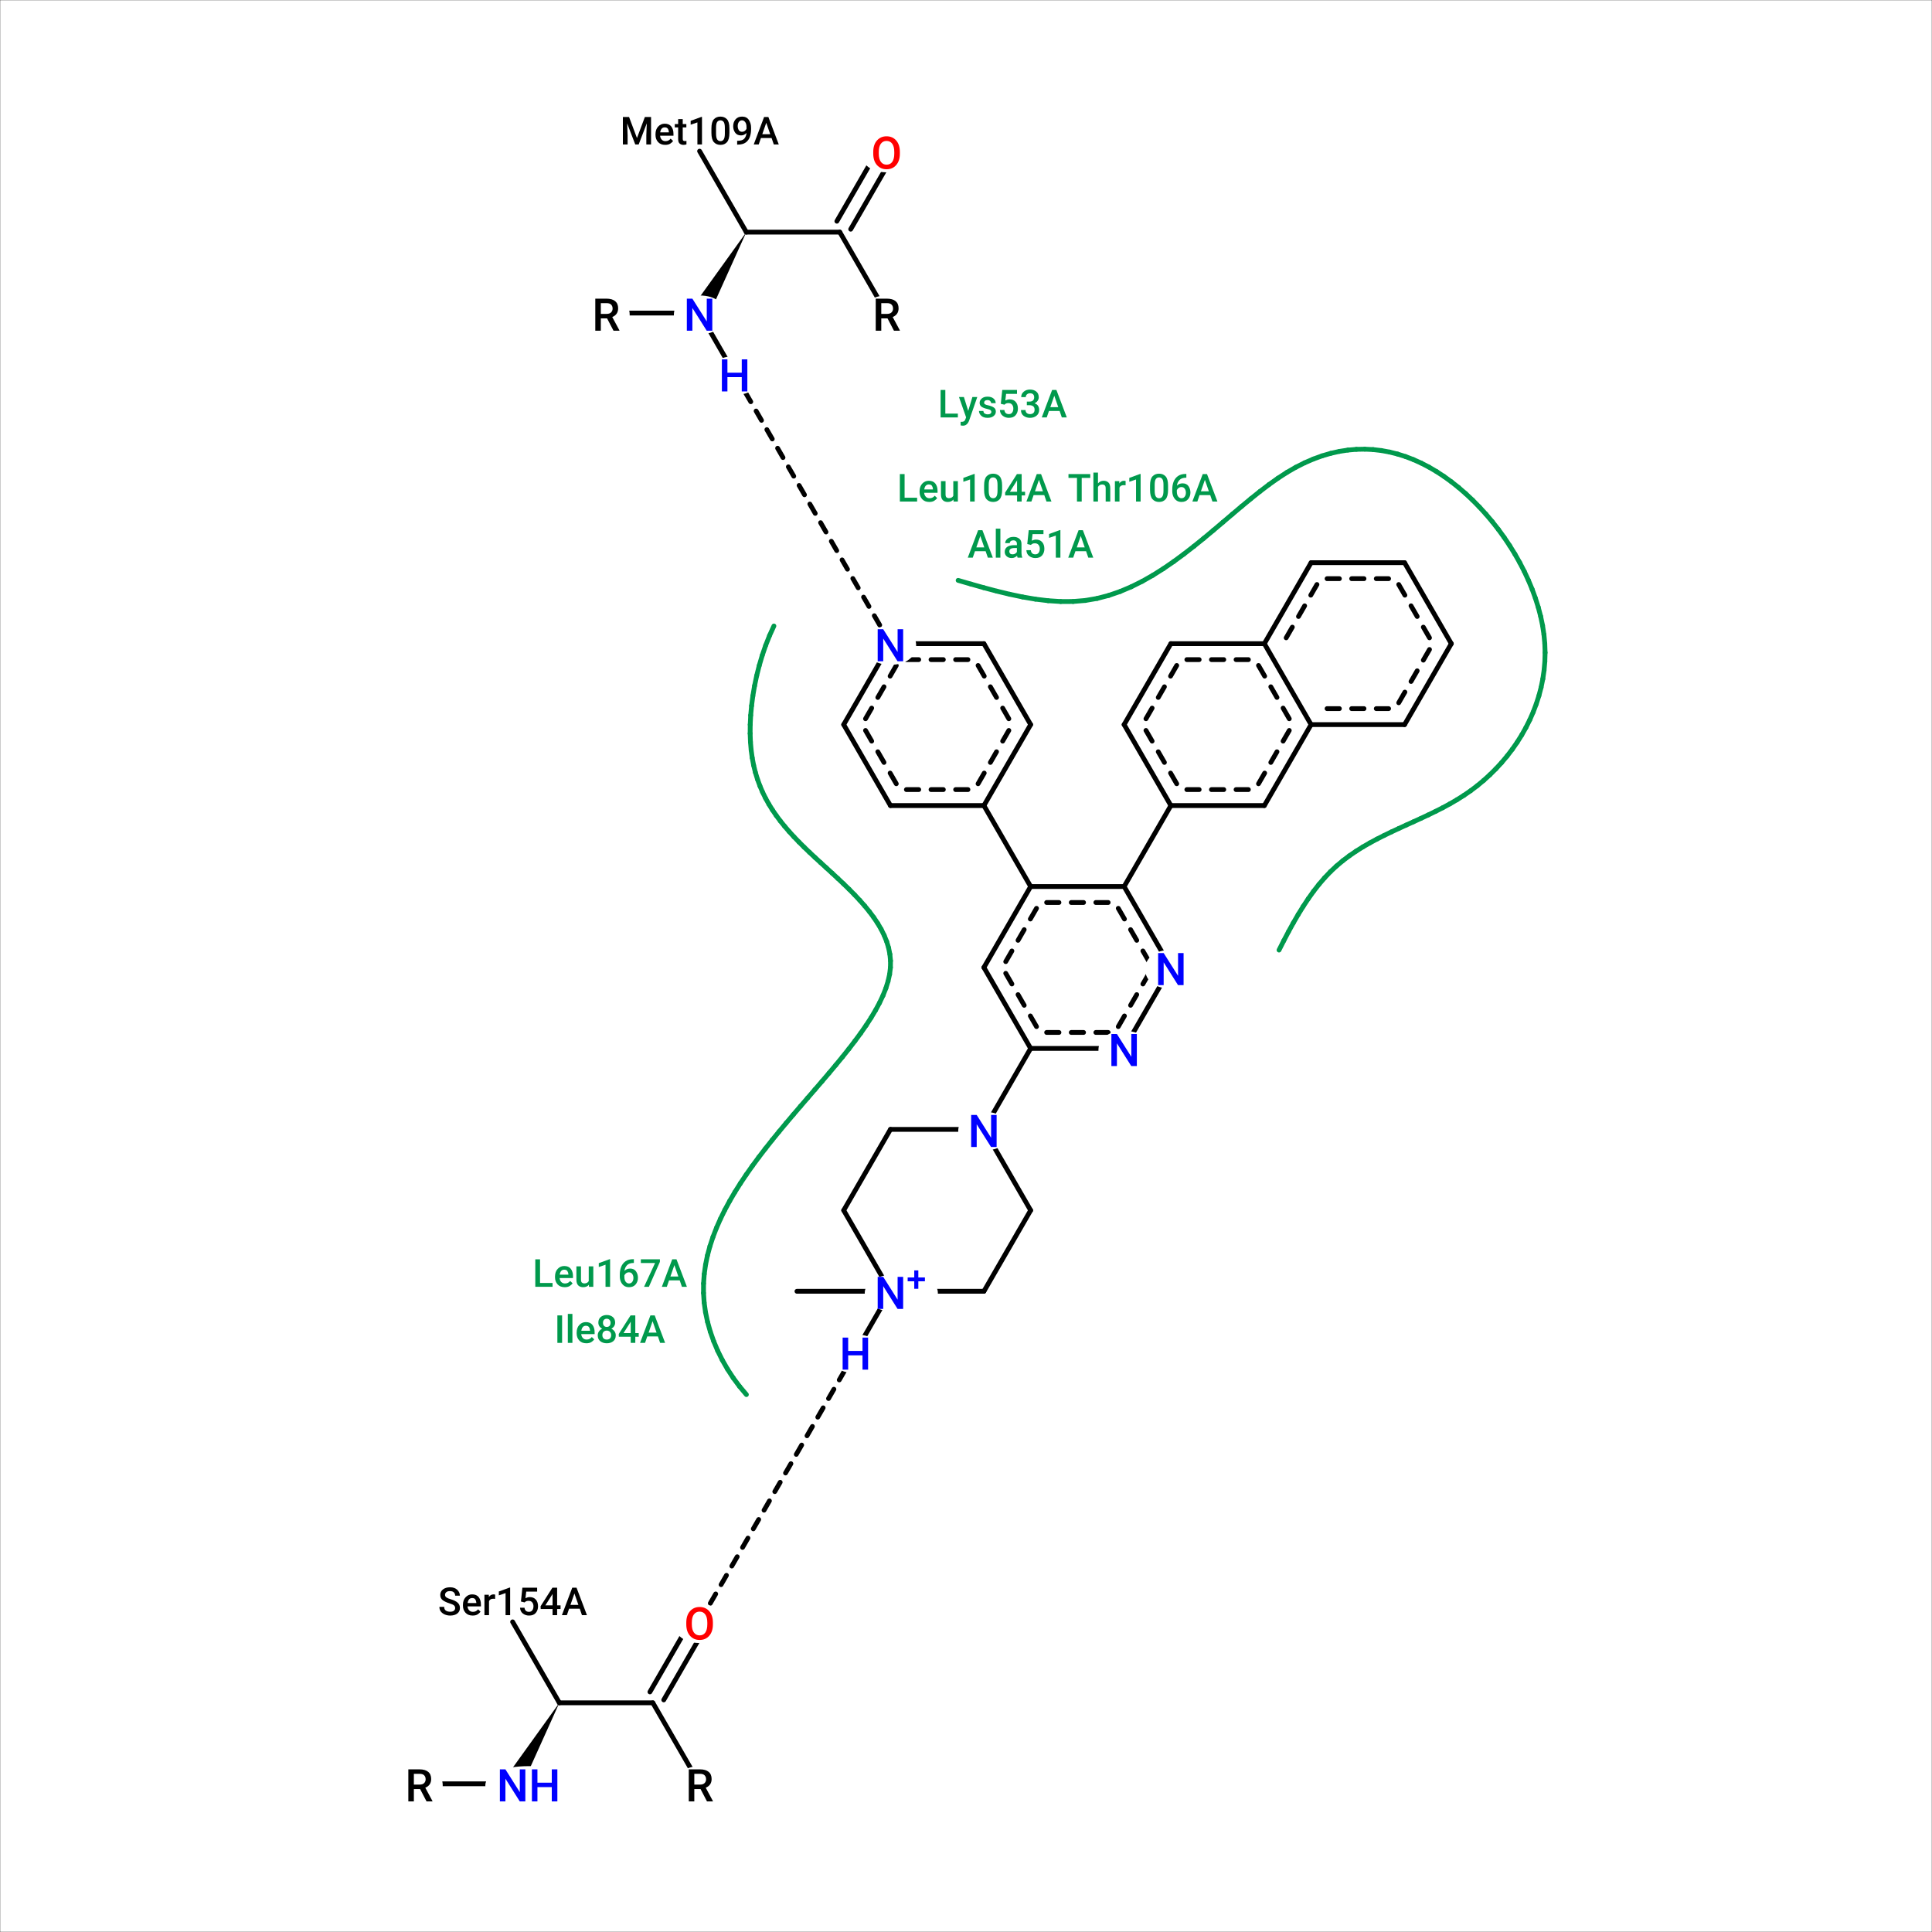

In [43]:
#FLAT View
response = requests.get(visuals['result_png_picture'])
img_data = BytesIO(response.content).getvalue()  # Get the raw bytes

display(Image(data=img_data, width=500, height=500))

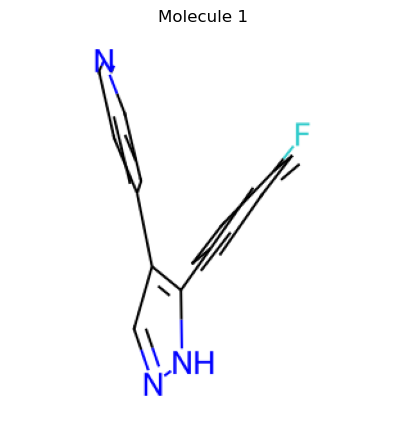

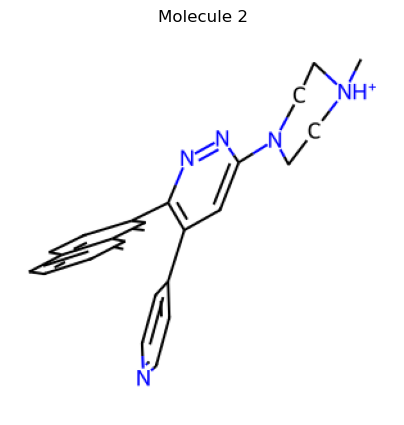

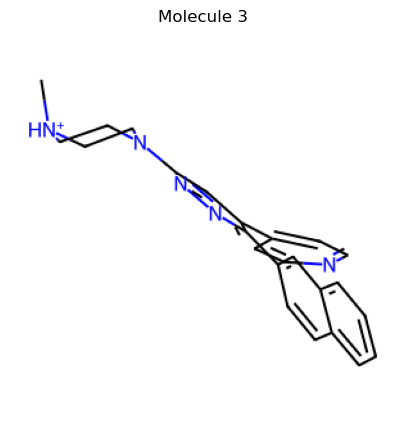

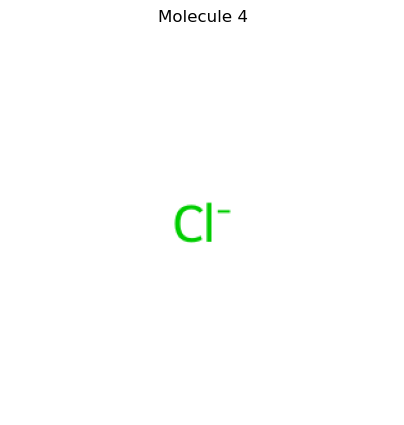

In [44]:
#3D Conformer represenattion
import tempfile

sdf_url = ligands

response = requests.get(sdf_url)
response.raise_for_status()  # Raise an error for unsuccessful requests

# Save the SDF data to a temporary file
with tempfile.NamedTemporaryFile(delete=False, suffix='.sdf') as temp_file:
    temp_file.write(response.content)
    temp_file_path = temp_file.name

# Create a supplier to read the SDF data
supplier = Chem.SDMolSupplier(temp_file_path)

# List to store the molecules
molecules = []

# Iterate through the supplier and add molecules to the list
for mol in supplier:
    if mol is not None:
        molecules.append(mol)

# Display each molecule as a separate image
if molecules:
    for i, mol in enumerate(molecules):
        fig, ax = plt.subplots(figsize=(5, 5))
        img = Draw.MolToImage(mol, size=(300, 300))
        ax.imshow(img)
        ax.axis('off')  # Hide the axes
        plt.title(f'Molecule {i + 1}')
        plt.show()
else:
    print("No molecules found in the SDF file.")


In [45]:
#Binding site prediction Dogsite3
chain = "A"
ligand_bias = "0" # 0 or 1
granulearity="0" #0 for properties or 1 for properties and druggability
dogsite_url = "https://proteins.plus/api/dogsite3_rest"
dogsite_payload = {
            "dogsite3": {
            "pdbCode":pdb_id,
            "analysisDetail":"1",
            "bindingSitePredictionGranularity": granulearity,
            "ligand":ligand_id,
            "chain":chain,
            "ligandBias":ligand_bias}
            }
response = requests.post(dogsite_url, json=dogsite_payload, headers=headers)

dogsite_result_location=response.json()['location']
dogsite_result_location

'https://proteins.plus/api/dogsite3_rest/N5cDZbj973iqhW1xiAH9gFSG'

In [46]:
res=requests.get(dogsite_result_location)
res.json()

{'status_code': 200,
 'result_table': 'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_desc.txt',
 'residues': ['https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_1_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_2_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_3_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_4_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_5_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_6_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_7_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_8_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_9_res.pdb',
  'https://proteins.plus/results/dogsite3/N5cDZbj973iqhW1xiAH9gFSG/4r3c_P_10_res.pdb'],
 'pocke

In [47]:
ligand_id

'3GF_A_402'